## Our Data Analysis

In [16]:
# Attatch the libraries
library(tidyverse)
library(tidymodels)
library(cowplot)
set.seed(2022)
options(repr.plot.width = 12, repr.plot.height = 8)

In [17]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data"

hungarian_data <- read_csv(url, col_names = c('age', 'sex', 'chest_pain', 'resting_blood_pressure', 'cholesterol', 
                                              'fasting_blood_sugar', 'resting_ecg', 'max_heart_rate', 'exercise_induced_angina',
                                              'st_depression', 'peak_st_slope', 'major_vessel_num', 'thal', 'diagnosis'))
head(hungarian_data)

Rows: 294 Columns: 14
-- Column specification ------------------------------------------------------------------------------------------------
Delimiter: ","
chr (9): resting_blood_pressure, cholesterol, fasting_blood_sugar, resting_e...
dbl (5): age, sex, chest_pain, st_depression, diagnosis

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,chest_pain,resting_blood_pressure,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,exercise_induced_angina,st_depression,peak_st_slope,major_vessel_num,thal,diagnosis
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>
28,1,2,130,132,0,2,185,0,0,?,?,?,0
29,1,2,120,243,0,0,160,0,0,?,?,?,0
29,1,2,140,?,0,0,170,0,0,?,?,?,0
30,0,1,170,237,0,1,170,0,0,?,?,6,0
31,0,2,100,219,0,1,150,0,0,?,?,?,0
32,0,2,105,198,0,0,165,0,0,?,?,?,0


In [18]:
hungarian_clean <- hungarian_data |>
    # Select applicable columns to use as predictors.
    select(age, resting_blood_pressure, cholesterol, max_heart_rate, diagnosis) |>
    # Change the diagnosis column to factor so that it can be used as the predicted result.
    mutate(diagnosis = as.factor(diagnosis))

# Mutate the data frame so that all of the numerical predictors are doubles rather than characters.             
as_double <- c("resting_blood_pressure", "cholesterol", "max_heart_rate")
hungarian_clean[as_double] <- lapply(hungarian_clean[as_double], as.double)

#Get rid of any rows with NA
hungarian_clean <- hungarian_clean |>
            filter_all(all_vars(!is.na(.)))

# View the cleaned dataframe.
glimpse(hungarian_clean)

Warning message in lapply(hungarian_clean[as_double], as.double):
"NAs introduced by coercion"
Warning message in lapply(hungarian_clean[as_double], as.double):
"NAs introduced by coercion"
Warning message in lapply(hungarian_clean[as_double], as.double):
"NAs introduced by coercion"


Rows: 270
Columns: 5
$ age                    <dbl> 28, 29, 30, 31, 32, 32, 32, 33, 34, 34, 34, 35,~
$ resting_blood_pressure <dbl> 130, 120, 170, 100, 105, 110, 125, 120, 130, 15~
$ cholesterol            <dbl> 132, 243, 237, 219, 198, 225, 254, 298, 161, 21~
$ max_heart_rate         <dbl> 185, 160, 170, 150, 165, 184, 155, 185, 190, 16~
$ diagnosis              <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,~


In [19]:
hungarian_split <- initial_split(hungarian_clean, prop = 0.75, strata = diagnosis)
hungarian_train <- training(hungarian_split)
hungarian_test <- testing(hungarian_split)

glimpse(hungarian_train)
glimpse(hungarian_test)

Rows: 201
Columns: 5
$ age                    <dbl> 28, 29, 30, 31, 32, 32, 32, 34, 35, 35, 35, 35,~
$ resting_blood_pressure <dbl> 130, 120, 170, 100, 105, 110, 125, 98, 120, 140~
$ cholesterol            <dbl> 132, 243, 237, 219, 198, 225, 254, 220, 160, 16~
$ max_heart_rate         <dbl> 185, 160, 170, 150, 165, 184, 155, 150, 185, 15~
$ diagnosis              <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,~
Rows: 69
Columns: 5
$ age                    <dbl> 33, 34, 34, 36, 37, 37, 38, 38, 39, 39, 40, 41,~
$ resting_blood_pressure <dbl> 120, 130, 150, 112, 130, 120, 120, 140, 110, 13~
$ cholesterol            <dbl> 298, 161, 214, 340, 211, 223, 275, 297, 182, 30~
$ max_heart_rate         <dbl> 185, 190, 168, 184, 142, 168, 129, 150, 180, 14~
$ diagnosis              <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,~


In [20]:
hungarian_recipe <- recipe(diagnosis ~ age + resting_blood_pressure + cholesterol + max_heart_rate, data = hungarian_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

hungarian_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          4

Operations:

Scaling for all_predictors()
Centering for all_predictors()

In the initialized recipe, we set the diagnosis as our target variable while setting age, resting blood pressure, cholesterol, and max heart rate to be our predictors. The predictors were then standardized(scaled and centered) to have a mean of 0 and a standard deviation of 1.

In [21]:
hungarian_vfold <- vfold_cv(hungarian_train, v = 5, strata = diagnosis)

Doing cross-validation in k-nearest neighbour classification will allow the best k to be picked accordingly to the accuracy that each k results in, where the k that gives the highest prediction accuracy will be chosen. 5-fold cross-validation tunes the model by splitting the overall training data into 5 even-sized groups, in which while 1 group of data is used as the validation set, the other 4 remaining groups are used as the training set. This process was then repeated 5 times (Dr. Campbell).


In [22]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


??? (SOME DESCRIPTION TO BE PUT DOWN)

In [23]:
tibble_made <- tibble(neighbors = seq(1, 30))

tibble_made

neighbors
<int>
1
2
3
4
5
6
7
8
9


In [24]:
results <- workflow() |>
  add_recipe(hungarian_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = hungarian_vfold, grid = tibble_made) |>
  collect_metrics() |>
  filter(.metric == "accuracy")

results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5818293,5,0.02108328,Preprocessor1_Model01
2,accuracy,binary,0.5818293,5,0.02108328,Preprocessor1_Model02
3,accuracy,binary,0.5970732,5,0.02517074,Preprocessor1_Model03
4,accuracy,binary,0.5970732,5,0.02517074,Preprocessor1_Model04
5,accuracy,binary,0.6018293,5,0.03392952,Preprocessor1_Model05
6,accuracy,binary,0.6018293,5,0.03392952,Preprocessor1_Model06
7,accuracy,binary,0.6317073,5,0.02928290,Preprocessor1_Model07
8,accuracy,binary,0.6317073,5,0.02928290,Preprocessor1_Model08
9,accuracy,binary,0.6320732,5,0.03754711,Preprocessor1_Model09


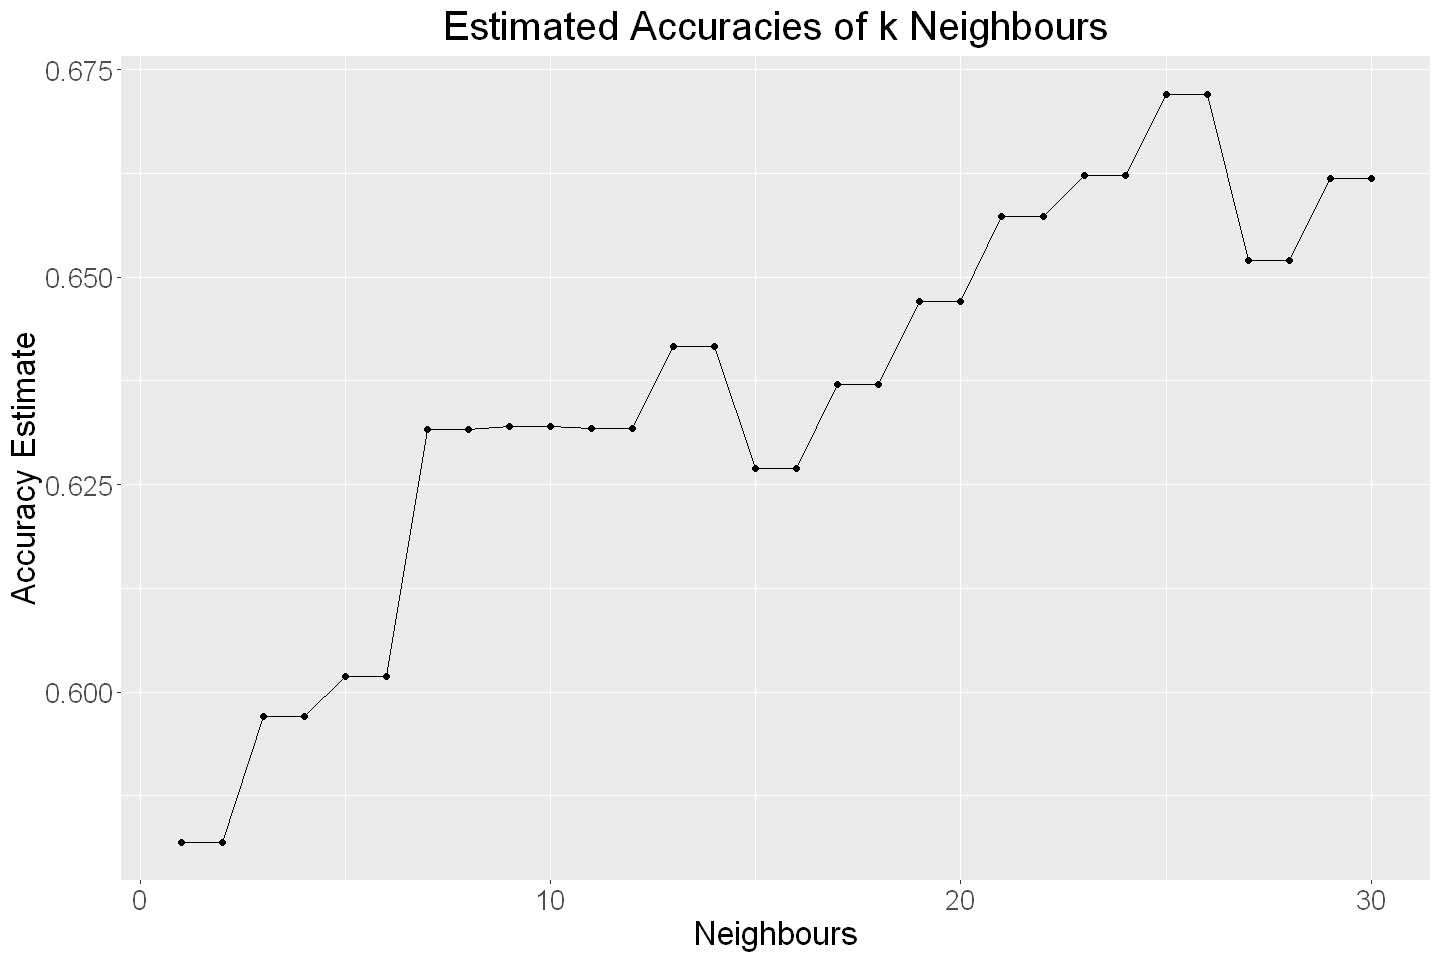

In [26]:
cross_val_plot <- results |> 
    ggplot(aes(x = neighbors, y = mean)) +
    geom_line() +
    geom_point() +
    labs(x = "Neighbours", y = "Accuracy Estimate", title = "Estimated Accuracies of k Neighbours") +
    theme(text = element_text(size=20), plot.title = element_text(hjust=0.5))

cross_val_plot

Visualizing the variance of estimated accuracies of the different number of k neighbours, and observed that there is an "elbow" at 21, 22 where the accuracy stops increasing dramatically and begins to level down or start to decrease (Dr. Campbell).

In [27]:
best_k <- results |>
    filter(mean == max(mean)) |>
    pull(neighbors)

best_k

[1] 25 26

In order to get a more accuracy number for k, we filtered the previous workflow that stored the estimated accuracy of each of the picked k to get the k that has the maximum accuracy mean. It is shown to be 21 and 22, where we have picked our k to be 21 as it is already a fairly large k and a higher k might result in overfitting or increase the chance of overfitting. 

In [28]:
knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 21) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_best_spec

hungarian_fit <- workflow() |>
  add_recipe(hungarian_recipe) |>
  add_model(knn_best_spec) |>
  fit(data = hungarian_train)

hungarian_fit

# Get the prediction column
hungarian_predictions <- predict(hungarian_fit, hungarian_test) |> 
    bind_cols(hungarian_test)

# Compare the accuracy of predictions to the true values in the test set
hungarian_accuracy <- hungarian_predictions |> 
    metrics(truth = diagnosis, estimate = .pred_class) |> 
    select(.metric, .estimate) |> 
    head(1)

hungarian_accuracy

# Compare the predictions to the true values in a confusion matrix
hungarian_comparison <- hungarian_predictions |> 
    conf_mat(truth = diagnosis, estimate = .pred_class)

hungarian_comparison

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 21
  weight_func = rectangular

Computational engine: kknn 


== Workflow [trained] ==================================================================================================
Preprocessor: Recipe
Model: nearest_neighbor()

-- Preprocessor --------------------------------------------------------------------------------------------------------
2 Recipe Steps

* step_scale()
* step_center()

-- Model ---------------------------------------------------------------------------------------------------------------

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(21,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3532338
Best kernel: rectangular
Best k: 21

.metric,.estimate
<chr>,<dbl>
accuracy,0.6666667


          Truth
Prediction  0  1
         0 36 16
         1  7 10